Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Beginning with the logistic regression model...

In [6]:
test_prediction_accuracy = []
reg_par = np.arange(0.0005, 0.004, 0.0001)
for i, beta in enumerate(reg_par):
    
  batch_size = 128

  graph = tf.Graph()
  with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    reg = tf.nn.l2_loss(weights)
    new_loss = loss + beta*reg

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(new_loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
      tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

  num_steps = 3001

  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    #print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      #if (step % 500 == 0):
        #print("Minibatch loss at step %d: %f" % (step, l))
        #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        #print("Validation accuracy: %.1f%%" % accuracy(
          #valid_prediction.eval(), valid_labels))
    #print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    test_prediction_accuracy.append(accuracy(test_prediction.eval(), test_labels))
    

The maxiumum test accuracy was 87.81 % and was achieved with beta = 0.0016


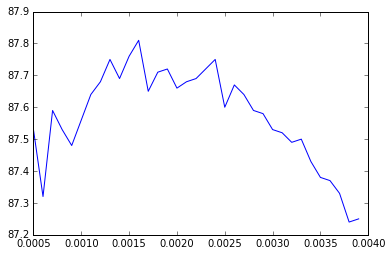

In [19]:
plt.plot(reg_par,test_prediction_accuracy)
beta = reg_par[test_prediction_accuracy.index(max(test_prediction_accuracy))]
print("The maxiumum test accuracy was", max(test_prediction_accuracy), "% and was achieved with beta =", beta)

Now we train the linear model with beta.

In [20]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    reg = tf.nn.l2_loss(weights)
    new_loss = loss + beta*reg

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(new_loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
      tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 500 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
          valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 14.946169
Minibatch accuracy: 12.5%
Validation accuracy: 16.7%
Minibatch loss at step 500: 1.137370
Minibatch accuracy: 75.0%
Validation accuracy: 76.3%
Minibatch loss at step 1000: 0.759638
Minibatch accuracy: 78.9%
Validation accuracy: 79.4%
Minibatch loss at step 1500: 0.852644
Minibatch accuracy: 78.1%
Validation accuracy: 80.7%
Minibatch loss at step 2000: 0.720361
Minibatch accuracy: 84.4%
Validation accuracy: 81.9%
Minibatch loss at step 2500: 0.469730
Minibatch accuracy: 85.9%
Validation accuracy: 82.6%
Minibatch loss at step 3000: 0.764444
Minibatch accuracy: 82.0%
Validation accuracy: 81.4%
Test accuracy: 87.7%


The validation and test accuracies achieved here are higher the accuracies seen in the model without regularization.

Now we add regularization to the neural network model.

In [17]:
test_prediction_accuracy = []
reg_par = np.arange(0, 0.00012, 0.00001)
for i, beta in enumerate(reg_par):

    batch_size = 128
    hidden_nodes = 1024

    graph = tf.Graph()
    with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)

      # Variables.
      weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
      biases1 = tf.Variable(tf.zeros([hidden_nodes]))
      weights2 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
      biases2 = tf.Variable(tf.zeros([num_labels]))

      # Training computation.
      print(beta)
      hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
      logits = tf.matmul(hidden_layer, weights2) + biases2
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
      reg = tf.nn.l2_loss(weights2)
      new_loss = loss + beta*reg

      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(new_loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      hidden_valid_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
      valid_prediction = tf.nn.softmax(
        tf.matmul(hidden_valid_layer, weights2) + biases2)
      hidden_test_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
      test_prediction = tf.nn.softmax(
        tf.matmul(hidden_test_layer, weights2) + biases2)

    num_steps = 3001
    
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        #print("Initialized")
        for step in range(num_steps):
          # Pick an offset within the training data, which has been randomized.
          # Note: we could use better randomization across epochs.
          offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
          # Generate a minibatch.
          batch_data = train_dataset[offset:(offset + batch_size), :]
          batch_labels = train_labels[offset:(offset + batch_size), :]
          # Prepare a dictionary telling the session where to feed the minibatch.
          # The key of the dictionary is the placeholder node of the graph to be fed,
          # and the value is the numpy array to feed to it.
          feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
          _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
          #if (step % 500 == 0):
            #print("Minibatch loss at step %d: %f" % (step, l))
            #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #print("Validation accuracy: %.1f%%" % accuracy(
              #valid_prediction.eval(), valid_labels))
        #print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        test_prediction_accuracy.append(accuracy(test_prediction.eval(), test_labels))


0.0
1e-05
2e-05
3e-05
4e-05
5e-05
6e-05
7e-05
8e-05
9e-05
0.0001
0.00011


The maxiumum test accuracy was 89.33 % and was achieved with beta = 8e-05


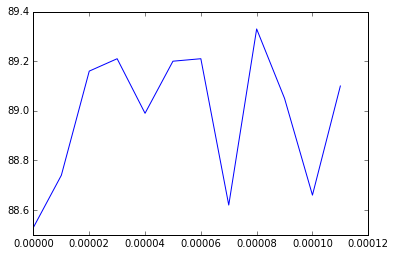

In [18]:
plt.plot(reg_par,test_prediction_accuracy)
beta = reg_par[test_prediction_accuracy.index(max(test_prediction_accuracy))]
print("The maxiumum test accuracy was", max(test_prediction_accuracy), "% and was achieved with beta =", beta)

Now we train the neural network with the new beta.

In [19]:
batch_size = 128
hidden_nodes = 1024
print(beta)
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(hidden_layer, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  reg = tf.nn.l2_loss(weights2)
  new_loss = loss + beta*reg

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(new_loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  hidden_valid_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_valid_layer, weights2) + biases2)
  hidden_test_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(
    tf.matmul(hidden_test_layer, weights2) + biases2)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 500 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
          valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

8e-05
Initialized
Minibatch loss at step 0: 392.603027
Minibatch accuracy: 10.2%
Validation accuracy: 31.9%
Minibatch loss at step 500: 16.437206
Minibatch accuracy: 76.6%
Validation accuracy: 80.1%
Minibatch loss at step 1000: 12.212330
Minibatch accuracy: 84.4%
Validation accuracy: 81.0%
Minibatch loss at step 1500: 7.242187
Minibatch accuracy: 77.3%
Validation accuracy: 79.1%
Minibatch loss at step 2000: 11.418255
Minibatch accuracy: 74.2%
Validation accuracy: 80.9%
Minibatch loss at step 2500: 4.194616
Minibatch accuracy: 83.6%
Validation accuracy: 82.3%
Minibatch loss at step 3000: 2.914857
Minibatch accuracy: 78.9%
Validation accuracy: 82.7%
Test accuracy: 88.6%


The validation and test accuracies here are higher than the ones achieved without regularization.

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [20]:
batch_size = 50
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(hidden_layer, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  reg = tf.nn.l2_loss(weights2)
  new_loss = loss + beta*reg

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(new_loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  hidden_valid_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_valid_layer, weights2) + biases2)
  hidden_test_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(
    tf.matmul(hidden_test_layer, weights2) + biases2)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 500 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
          valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 361.740234
Minibatch accuracy: 12.0%
Validation accuracy: 32.2%
Minibatch loss at step 500: 35.391491
Minibatch accuracy: 82.0%
Validation accuracy: 76.1%
Minibatch loss at step 1000: 23.429144
Minibatch accuracy: 86.0%
Validation accuracy: 75.1%
Minibatch loss at step 1500: 10.590626
Minibatch accuracy: 72.0%
Validation accuracy: 77.8%
Minibatch loss at step 2000: 18.853075
Minibatch accuracy: 66.0%
Validation accuracy: 76.4%
Minibatch loss at step 2500: 2.251117
Minibatch accuracy: 82.0%
Validation accuracy: 77.5%
Minibatch loss at step 3000: 3.354944
Minibatch accuracy: 72.0%
Validation accuracy: 76.6%
Test accuracy: 82.8%


The test accuracy has fallen!

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

Introducing dropout for the non-overfitting case...

In [22]:
batch_size = 128
hidden_nodes = 1024
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  hidden_layer = tf.nn.dropout(hidden_layer, keep_prob = 0.5)
  logits = tf.matmul(hidden_layer, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  reg = tf.nn.l2_loss(weights2)
  new_loss = loss + beta*reg

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(new_loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  hidden_valid_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_valid_layer, weights2) + biases2)
  hidden_test_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(
    tf.matmul(hidden_test_layer, weights2) + biases2)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 500 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
          valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

8e-05
Initialized
Minibatch loss at step 0: 494.160309
Minibatch accuracy: 13.3%
Validation accuracy: 34.5%
Minibatch loss at step 500: 25.324768
Minibatch accuracy: 64.8%
Validation accuracy: 81.2%
Minibatch loss at step 1000: 19.668694
Minibatch accuracy: 72.7%
Validation accuracy: 80.2%
Minibatch loss at step 1500: 11.170761
Minibatch accuracy: 73.4%
Validation accuracy: 79.2%
Minibatch loss at step 2000: 5.513057
Minibatch accuracy: 71.9%
Validation accuracy: 80.0%
Minibatch loss at step 2500: 6.642831
Minibatch accuracy: 75.8%
Validation accuracy: 80.6%
Minibatch loss at step 3000: 6.099822
Minibatch accuracy: 71.9%
Validation accuracy: 80.6%
Test accuracy: 87.6%


Introducing dropout for the overfitting case...

In [25]:
batch_size = 50
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  hidden_layer = tf.nn.dropout(hidden_layer, keep_prob = 0.5)
  logits = tf.matmul(hidden_layer, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  reg = tf.nn.l2_loss(weights2)
  new_loss = loss + beta*reg

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(new_loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  hidden_valid_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_valid_layer, weights2) + biases2)
  hidden_test_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(
    tf.matmul(hidden_test_layer, weights2) + biases2)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 500 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
          valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 460.918915
Minibatch accuracy: 8.0%
Validation accuracy: 28.7%
Minibatch loss at step 500: 190.956177
Minibatch accuracy: 72.0%
Validation accuracy: 77.2%
Minibatch loss at step 1000: 309.686920
Minibatch accuracy: 74.0%
Validation accuracy: 73.2%
Minibatch loss at step 1500: 128.150955
Minibatch accuracy: 66.0%
Validation accuracy: 71.3%
Minibatch loss at step 2000: 370.517822
Minibatch accuracy: 58.0%
Validation accuracy: 67.8%
Minibatch loss at step 2500: 20.480024
Minibatch accuracy: 74.0%
Validation accuracy: 70.2%
Minibatch loss at step 3000: 24.573271
Minibatch accuracy: 60.0%
Validation accuracy: 68.6%
Test accuracy: 74.3%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [27]:
batch_size = 128
hidden_nodes = 1024
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  hidden_layer = tf.nn.dropout(hidden_layer, keep_prob = 0.5)
  logits = tf.matmul(hidden_layer, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  reg = tf.nn.l2_loss(weights2)
  new_loss = loss + beta*reg

  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.5)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  hidden_valid_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_valid_layer, weights2) + biases2)
  hidden_test_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(
    tf.matmul(hidden_test_layer, weights2) + biases2)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 500 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
          valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 492.219513
Minibatch accuracy: 10.2%
Validation accuracy: 41.5%
Minibatch loss at step 500: 23.315767
Minibatch accuracy: 71.1%
Validation accuracy: 81.5%
Minibatch loss at step 1000: 11.620200
Minibatch accuracy: 77.3%
Validation accuracy: 81.8%
Minibatch loss at step 1500: 11.867019
Minibatch accuracy: 76.6%
Validation accuracy: 81.8%
Minibatch loss at step 2000: 5.390252
Minibatch accuracy: 72.7%
Validation accuracy: 82.7%
Minibatch loss at step 2500: 5.117272
Minibatch accuracy: 81.2%
Validation accuracy: 83.0%
Minibatch loss at step 3000: 2.755826
Minibatch accuracy: 75.8%
Validation accuracy: 83.0%
Test accuracy: 89.3%
